In [23]:
import pandas as pd 
import requests
import json
import time


BASE_URL = "https://jiji.com.et/api_web/v1/listing"

PARAMS = {
    "filter_attr_179_property_type": "Condo", 
    "slug": "houses-apartments-for-rent", 
    "init_page": "true", #for prginstion
    "page": 1, # setting the first page
    "webp": "true" # images in a webp format
}

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept": "application/json"
}


#  function to normalize each listing 
def normalize_listing(item): #logic for transforming a single raw list dictionary (from the Jiji API) into a cleaner, flattened dictionary
    condo = {}
    condo["title"] = item.get("title")
    condo["url"] = "https://jiji.com.et" + item.get("url", "")
    condo["region"] = item.get("region")

    price_obj = item.get("price_obj", {}) # price obj is a nested dictionary 
    condo["price"] = price_obj.get("value")
    condo["price_display"] = price_obj.get("view")

    condo["bedrooms"] = None
    condo["bathrooms"] = None
    condo["furnishing"] = None
    condo["size_sqm"] = None

    for attr in item.get("attrs", []):
        if attr.get("name") == "Bedrooms": # go inside the attrs nested dictionary and get the name if the name is BEdrrom go and fetch the value and assign it to bedroom
            condo["bedrooms"] = attr.get("value")
        elif attr.get("name") == "Bathrooms":
            condo["bathrooms"] = attr.get("value")
        elif attr.get("name") == "Furnishing":
            condo["furnishing"] = attr.get("value")
        elif attr.get("name") == "Property size":
            condo["size_sqm"] = attr.get("value")

    condo["image_url"] = item.get("image_obj", {}).get("url")

    return condo

def scrape_listings(max_pages=3):
    
    all_listings = []
    current_page = 1

    while current_page <= max_pages:
        print(f"fetching page {current_page}")

        current_params = PARAMS.copy()
        current_params["page"] = current_page

        try:
            #send request
            response = requests.get(BASE_URL, params=current_params, headers=HEADERS, timeout=15)
            data = response.json()
            print(json.dumps(list(data.keys()), indent=2))
           

            if response.status_code == 200:
                
                if data.get('status') == 'ok' and 'adverts_list' in data:
                    listings = data['adverts_list'].get('adverts', [])
                else:
                     print("Unexpected JSON structure.... stopping.")
                     print(json.dumps(data, indent=2, ensure_ascii=False))
                     break
                    

                if listings: 
                     all_listings.extend(listings)
                     print(f"added {len(listings)} listings from page {current_page}\n")
                     current_page += 1
                     time.sleep(2)
                else:
                     print(f" No more listings found on page {current_page}.. Stoppin.\n")
                     break
                
            elif response.status_code == 404:
                print(f" Page {current_page} not found (404) Stopping\n")
                break
            else:
                print(f"Error fetching page {current_page} Status: {response.status_code}")
                print(response.text[:200])  
                break

        except requests.exceptions.Timeout:
            print(f" Request timed out for page {current_page}")
            break
        except requests.exceptions.ConnectionError:
            print(f" Connection error on page {current_page} Check your internet")
            break
        except requests.exceptions.RequestException as e:
            print(f" Unexpected error: {e}")
            break

    return all_listings

# --- Main execution ---
if __name__ == "__main__":
    print("Starting Jiji Condo Scraper...")
    scraped_condos = scrape_listings(max_pages=3)  

    print(f"\nScraping complete! Total condos found: {len(scraped_condos)}")

    if scraped_condos:
        df_raw = pd.DataFrame(scraped_condos)
        df_raw.to_csv("jiji_scrapped_raw.csv", index=False, encoding="utf-8")
        df_raw.to_json("jiji_scrapped_raw.json", orient="records", indent=4)
        print("\nFull raw data saved to jiji_scrapped_raw.csv and jiji_scrapped_raw.json")
            
            # Save a small sample of the raw data (e.g., first 50 rows)
        df_raw.head(10).to_csv("jiji_scrapped_sample.csv", index=False)
        df_raw.head(10).to_json("jiji_scrapped_sample.json", orient="records", indent=4)
        print("Sample raw data saved to jiji_scrapped_sample.csv and jiji_scrapped_sample.json")
    else:
        print("No listings were scraped. No files will be created.")
            
           

    if scraped_condos:
        # Normalize the listings
        normalized_listings = [] # empty list
        for item in scraped_condos: 
            normalized_item = normalize_listing(item)
            normalized_listings.append(normalized_item) 
        

        df_condos = pd.DataFrame(normalized_listings)

        print("\n--- Pandas DataFrame created ---")
       
        try: #saving JSOn
            
            with open("jiji_condos_normalized.json", "w", encoding="utf-8") as f:
                json.dump(normalized_listings, f, indent=2, ensure_ascii=False)
            print("\nNormalized data saved to jiji_condos_normalized.json")
        except Exception as e:
            print(f"Error saving normalized JSON: {e}")

       
        try: #saving as CSV
            df_condos.to_csv("jiji_condos_normalized.csv", index=False, encoding="utf-8")
            
            Sample = df_condos[df_condos['price'] < 50000].head(10)
            Sample.head(10).to_csv("Sample_Normalised_data.csv", index=False)
            
            df_condos.dtypes
            
            print("\nNormalized data saved to jiji_condos_normalized.csv")
            print("\nNormalized sample data saved to jiji_condos_normalized.csv")
        except Exception as e:
            print(f"Error saving normalized CSV: {e}")

    else:
        print("No condos were scraped.")


Starting Jiji Condo Scraper...
fetching page 1
[
  "adverts_list",
  "companies_search",
  "next_url",
  "status",
  "listing_id",
  "extra_data",
  "banners",
  "banners_v2",
  "sort_data",
  "period",
  "seo",
  "seo_node_info",
  "search_params",
  "saved_search",
  "search",
  "adult_only",
  "has_price_valuation",
  "breadcrumbs",
  "show_ads",
  "search_categories",
  "adsense_targeting"
]
added 13 listings from page 1

fetching page 2
[
  "adverts_list",
  "companies_search",
  "next_url",
  "status",
  "listing_id",
  "extra_data"
]
added 13 listings from page 2

fetching page 3
[
  "adverts_list",
  "companies_search",
  "next_url",
  "status",
  "listing_id",
  "extra_data"
]
added 13 listings from page 3


Scraping complete! Total condos found: 39

Full raw data saved to jiji_scrapped_raw.csv and jiji_scrapped_raw.json
Sample raw data saved to jiji_scrapped_sample.csv and jiji_scrapped_sample.json

--- Pandas DataFrame created ---

Normalized data saved to jiji_condos_normal

Data loaded successfully for visualization


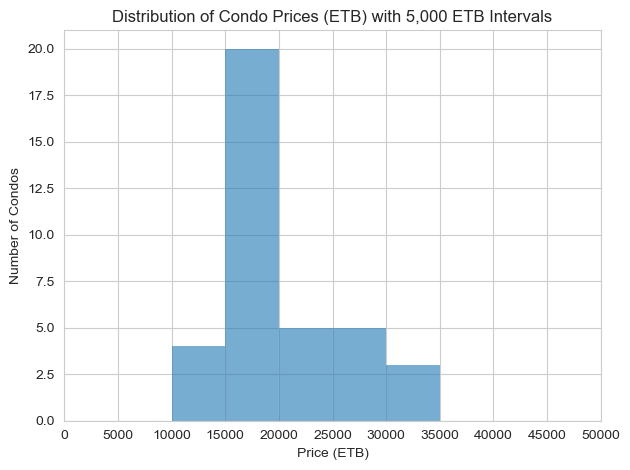

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
try:
    df_condos = pd.read_csv("jiji_condos_normalized.csv")
    print("Data loaded successfully for visualization")
except FileNotFoundError:
    print("Error: 'jiji_condos_normalized.csv' not found.")
    exit()

# Set visual style
sns.set_style("whitegrid")

# Define bin width and create price bins in 5000 ETB intervals
bin_width = 5000
min_price = 0
max_price = df_condos['price'].max()
price_bins = np.arange(min_price, max_price + bin_width, bin_width)

# Create the histogram with KDE overlay

sns.histplot(
    df_condos['price'],
    bins=price_bins,
    alpha=0.6,
    
)

# Plot titles and labels
plt.title('Distribution of Condo Prices (ETB) with 5,000 ETB Intervals')
plt.xlabel('Price (ETB)')
plt.ylabel('Number of Condos')

# Format x-axis
plt.xlim(0, 50000)
plt.xticks(np.arange(0, 50001, 5000))
  # Show 0, 5000, 10000, ..., 50000
plt.ticklabel_format(style='plain', axis='x')  # Prevent scientific notation

# Show the plot
plt.tight_layout()
plt.show()


In [3]:
df_condos.dtypes

title            object
url              object
region           object
price             int64
price_display    object
bedrooms          int64
bathrooms         int64
furnishing       object
size_sqm          int64
image_url        object
dtype: object

In [10]:
df_condos.groupby("bedrooms")["price"].mean() 

bedrooms
1    17400.000000
2    18550.000000
3    21866.666667
Name: price, dtype: float64

In [6]:
import pandas as pd
import numpy as np

# average price function
def calculate_average_price_by_bedrooms(df):
    
    if df.empty:
        print("Input DataFrame is empty. Cannot calculate averages.")
        return None

    # Filter out extremely high bedroom counts that might be outliers or sparse data
    relevant_bedrooms_df = df[df['bedrooms'] >= 0].copy() 
    relevant_bedrooms_df = relevant_bedrooms_df[relevant_bedrooms_df['bedrooms'] <= 3].copy()

    if relevant_bedrooms_df.empty:
        print("No relevant bedroom data (0-3 bedrooms) found in the DataFrame to calculate averages.")
        return None

    average_prices = relevant_bedrooms_df.groupby('bedrooms')['price'].mean().reset_index()
    average_prices = average_prices.sort_values(by='bedrooms')
    average_prices['average_price_etb'] = average_prices['price'].apply(lambda x: f'{x:,.2f}')

    return average_prices[['bedrooms', 'average_price_etb']]

try:
    df_condos = pd.read_csv("jiji_condos_normalized.csv")
    print("Data loaded successfully from 'jiji_condos_normalized.csv'.")
except FileNotFoundError:
    print("Error: 'jiji_condos_normalized.csv' not found.")

df_analysis = df_condos.copy()
df_analysis['price'] = pd.to_numeric(df_analysis['price'], errors='coerce')
df_analysis['bedrooms'] = pd.to_numeric(df_analysis['bedrooms'], errors='coerce')
df_analysis['bathrooms'] = pd.to_numeric(df_analysis['bathrooms'], errors='coerce')
df_analysis['size_sqm'] = pd.to_numeric(df_analysis['size_sqm'], errors='coerce')
df_analysis.dropna(subset=['price', 'bedrooms', 'bathrooms', 'size_sqm'], inplace=True)
df_analysis = df_analysis[df_analysis['price'] > 0]
df_analysis = df_analysis[df_analysis['bedrooms'] >= 0]
df_analysis = df_analysis[df_analysis['bathrooms'] >= 0]
df_analysis = df_analysis[df_analysis['size_sqm'] > 0]

df_analysis['bedrooms'] = df_analysis['bedrooms'].astype(int)

df_analysis_filtered = df_analysis[df_analysis['price'] <= 100000].copy()

print("\n--- Using the 'calculate_average_price_by_bedrooms' function ---")
average_prices_result = calculate_average_price_by_bedrooms(df_analysis_filtered)

if average_prices_result is not None:
    print(average_prices_result)
    print("\nNote: Prices are in ETB.")
else:
    print("Could not calculate averages. Please check the data.")

Data loaded successfully from 'jiji_condos_normalized.csv'.

--- Using the 'calculate_average_price_by_bedrooms' function ---
   bedrooms average_price_etb
0         1         19,000.00
1         2         16,750.00
2         3         22,750.00

Note: Prices are in ETB.
